In [1]:
import fastf1
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from fastf1.ergast import Ergast
from sklearn.metrics import mean_absolute_error, mean_squared_error
pd.set_option('display.float_format', '{:.3f}'.format)

import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
#sess = fastf1.get_session(2023, 'Abu Dhabi Grand Prix', 'R')
#sess.load()

In [2]:
df_all = pd.read_csv('/Users/macbook/Documents/fastf1/race_data/race_data_2018_2023.csv')
df_all.info()

/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_94665/2430009690.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv('/Users/macbook/Documents/fastf1/race_data/race_data_2018_2023.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136062 entries, 0 to 136061
Data columns (total 34 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Time                136062 non-null  object 
 1   Driver              136062 non-null  object 
 2   DriverNumber        136062 non-null  int64  
 3   LapTime             133354 non-null  float64
 4   LapNumber           136062 non-null  float64
 5   Stint               135719 non-null  float64
 6   PitOutTime          4367 non-null    float64
 7   PitInTime           4513 non-null    float64
 8   Sector1Time         133111 non-null  float64
 9   Sector2Time         135757 non-null  float64
 10  Sector3Time         135625 non-null  float64
 11  Sector1SessionTime  132789 non-null  object 
 12  Sector2SessionTime  135757 non-null  object 
 13  Sector3SessionTime  135625 non-null  object 
 14  SpeedI1             116594 non-null  float64
 15  SpeedI2             135705 non-nul

In [3]:
def preprocess_data(df, map_compound=True, map_teams=False):
    # Create a copy of the input DataFrame
    df_copy = df.copy()

    # If needed map the old team names to the 2023 ones
    if map_teams:
      team_name_mapping = {
         'Force India': 'Aston Martin',
         'Racing Point': 'Aston Martin',
         'Toro Rosso': 'AlphaTauri',
         'Sauber': 'Alfa Romeo',
         'Alfa Romeo Racing': 'Alfa Romeo',
         'Renault': 'Alpine'
      }
      # Replace the old team names with the new ones in the 'Team' column
      df_copy['Team'] = df_copy['Team'].replace(team_name_mapping)

    if map_compound:
      compound_mapping = {
         'HYPERSOFT':1,'ULTRASOFT':2, 'SUPERSOFT':3, 'SOFT':4,
         'MEDIUM':5,'HARD':6, 'INTERMEDIATE':7, 'WET':8, 'UNKNOWN':0
      }
      
      df_copy['Compound'] = df_copy['Compound'].fillna('UNKNOWN')
      df_copy['Compound'] = df_copy['Compound'].replace(compound_mapping)
      
   

    df_copy['TrackStatus'] = df_copy['TrackStatus'].astype(str)
    df_copy['PitIn'] = df_copy['PitInTime'].notnull()
    df_copy['PitOut'] = df_copy['PitOutTime'].notnull()
    

    df_copy = df_copy.drop(['Time','PitInTime','PitOutTime','Sector1SessionTime','Sector2SessionTime', 'Sector3SessionTime','LapStartTime',
       'LapStartDate','Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'], axis=1)

    # Return the preprocessed DataFrame
    return df_copy

In [4]:
df_all = preprocess_data(df_all, map_compound=True)

/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_94665/832340770.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['Compound'] = df_copy['Compound'].replace(compound_mapping)


In [6]:
def get_round_number(year, race):
    schedule = fastf1.get_event_schedule(year)
    round_number = schedule[schedule['EventName'] == race]['RoundNumber'].values[0]
    
    return round_number

In [7]:
def get_team_standings_map(ergast_team_standings_df, race_df):
    # Create a dictionary from the ergast_team_standings_df DataFrame
    team_standings_map = dict(zip(ergast_team_standings_df['constructorName'], ergast_team_standings_df['position']))

    # Iterate over the unique team names in the race_df DataFrame
    for team in race_df['Team'].unique():
        # Find the key in the dictionary that is a substring of the team name or vice versa
        matching_keys = [key for key in team_standings_map.keys() if key in team or team in key]
        if matching_keys:
            # Add a new entry to the dictionary
            team_standings_map[team] = team_standings_map[matching_keys[0]]

    # Return the modified dictionary
    return team_standings_map

In [5]:
def filter_for_race(df, race_name, year, team_encode=False):

    # Filter the DataFrame by the grand prix name and the range of years
    filtered_df = df[(df['RaceName'] == race_name) & (df['Year']==year)]

    # If the 'Team' column should be encoded, replace the team names with standings at race:
    if team_encode:
        # Get the round number for the given race
        round = get_round_number(year, race_name)
        # If first round use last year's final standings
        if round == 1:
            year -= 1
        ergast = Ergast()
        standings = ergast.get_constructor_standings(season=year, round=round-1)
        team_standings = standings.content[0]
        team_standings = team_standings[['constructorName', 'position']]
        team_standings_map = get_team_standings_map(team_standings, filtered_df)
        filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)


    # Return the filtered DataFrame
    return filtered_df

In [6]:
df_race = filter_for_race(df_all, 'Abu Dhabi Grand Prix', 2023, team_encode=False)

In [7]:
def remove_slow_laps(df, threshold=1.07):
    # Group by driver and apply the slow lap removal logic within each group
    def process_driver(group):
        max_allowed_lap_time = group['LapTime'].min() * threshold
        group['LapTime'] = group['LapTime'].where(group['LapTime'] < max_allowed_lap_time, np.nan)
        group['LapTime'] = group['LapTime'].ffill()
        return group

    # Apply the function per driver
    df = df.groupby(['Year', 'RaceName', 'Driver']).apply(process_driver).reset_index(drop=True)

    return df

In [8]:
df_race = remove_slow_laps(df_race)

/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_94665/888154003.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['Year', 'RaceName', 'Driver']).apply(process_driver).reset_index(drop=True)


Remember to remove slow laps before training tho!

In [9]:
def add_lags(df, num_lags):
    # Sort the DataFrame
    df.sort_values(by=['Year', 'RaceName', 'Driver', 'LapNumber'], inplace=True)

    # Create lagged features
    for i in range(1, num_lags + 1):
        df[f'LapTime_Lag{i}'] = df.groupby(['Year', 'RaceName', 'Driver'])['LapTime'].shift(i)
        #df[f'Sector1Time_Lag{i}'] = df.groupby(['Year', 'RaceName', 'Driver'])['Sector1Time'].shift(i)
        #df[f'Sector2Time_Lag{i}'] = df.groupby(['Year', 'RaceName', 'Driver'])['Sector2Time'].shift(i)
        #df[f'Sector3Time_Lag{i}'] = df.groupby(['Year', 'RaceName', 'Driver'])['Sector3Time'].shift(i)

    # Return the DataFrame with the lagged features
    return df

In [10]:
df_race = add_lags(df_race, 3)

In [ ]:
def add_laptime_diff(df, driver):
    # Create the 'LapTime_Diff' feature for the specified driver
    df.loc[df['Driver'] == driver, 'LapTime_Diff'] = df[df['Driver'] == driver]['LapTime'] - df[df['Driver'] == driver]['LapTime'].shift(1)

    # Return the DataFrame with the 'LapTime_Diff' feature
    return df

Train xgb on historic data for laptime difference normalized for track length? Recent historic only? 

In [11]:
def add_rolling_mean(df, window=3):
    df = df.reset_index(drop=True)

    df['RollingMean'] = df.groupby(['Year','RaceName',
                                    'Driver'])['LapTime'].transform(lambda x: x.shift(1).rolling(window=window).mean())
    return df

In [12]:
df_race = add_rolling_mean(df_race)

In [13]:
def add_stint_mean(df):
    df = df.reset_index(drop=True)
    
    df['StintMean'] = df.groupby([
        'Year', 'RaceName',
        'Driver', 'Stint'])['LapTime'].transform(lambda x: x.shift(1).expanding().mean())

    return df

In [14]:
def add_stint_median(df):
    df = df.reset_index(drop=True)

    df['StintMedian'] = df.groupby(['Year', 'RaceName',
                                    'Driver', 'Stint'])['LapTime'].transform(lambda x: x.shift(1).expanding().median())

    return df


In [46]:
df_race = add_stint_median(df_race)

In [16]:
df_race = add_stint_mean(df_race)

In [33]:
df_race = add_rolling_mean(df_race)

In [12]:
def train_test_split(df,lap):
    # Use data from before the given lap as training data
    train_data = df[df['LapNumber'] <= lap]
    
    # Use data from the given lap onwards as test data
    test_data = df[df['LapNumber'] > lap]
    
    return train_data, test_data

In [39]:
def driver_split(df, driver_behind, driver_front):
    # Split the DataFrame into two DataFrames, one for the driver behind and one for the driver in front
    df_behind = df[df['Driver'] == driver_behind]
    df_front = df[df['Driver'] == driver_front]
    
    return df_behind, df_front

In [69]:
df_behind, df_front = driver_split(df_race, 'VER', 'ALB')


In [71]:
df_behind.columns

Index(['Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2',
       'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife',
       'FreshTyre', 'Team', 'TrackStatus', 'Position', 'CumulativeTime',
       'Year', 'RaceName', 'PitIn', 'PitOut', 'LapTime_Lag1',
       'Sector1Time_Lag1', 'Sector2Time_Lag1', 'Sector3Time_Lag1',
       'LapTime_Lag2', 'Sector1Time_Lag2', 'Sector2Time_Lag2',
       'Sector3Time_Lag2', 'LapTime_Lag3', 'Sector1Time_Lag3',
       'Sector2Time_Lag3', 'Sector3Time_Lag3', 'LapTime_Lag4',
       'Sector1Time_Lag4', 'Sector2Time_Lag4', 'Sector3Time_Lag4',
       'LapTime_Lag5', 'Sector1Time_Lag5', 'Sector2Time_Lag5',
       'Sector3Time_Lag5', 'LapTime_Lag6', 'Sector1Time_Lag6',
       'Sector2Time_Lag6', 'Sector3Time_Lag6', 'LapTime_RollingMean_3',
       'StintAverage'],
      dtype='object')

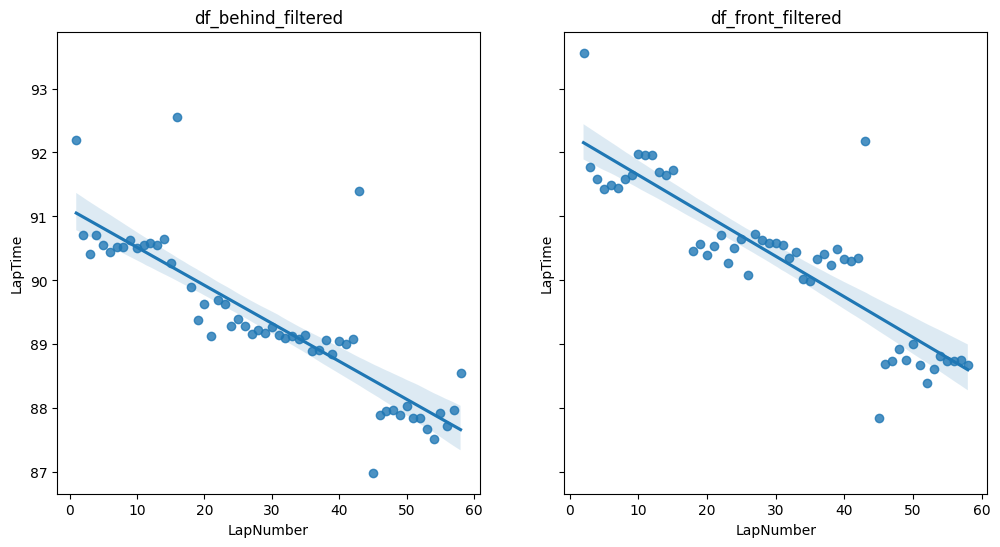

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

# Plot df_behind_filtered['LapTime'] and df_behind_filtered['LapTimeLag_1'] on the first subplot
sns.regplot(x='LapNumber', y='LapTime', data=df_behind, ax=ax1)
ax1.set_title('df_behind_filtered')

# Plot df_front_filtered['LapTime'] and df_front_filtered['LapTimeLag_1'] on the second subplot
sns.regplot(x='LapNumber', y='LapTime', data=df_front, ax=ax2)
ax2.set_title('df_front_filtered')

# Display the plots
plt.show()

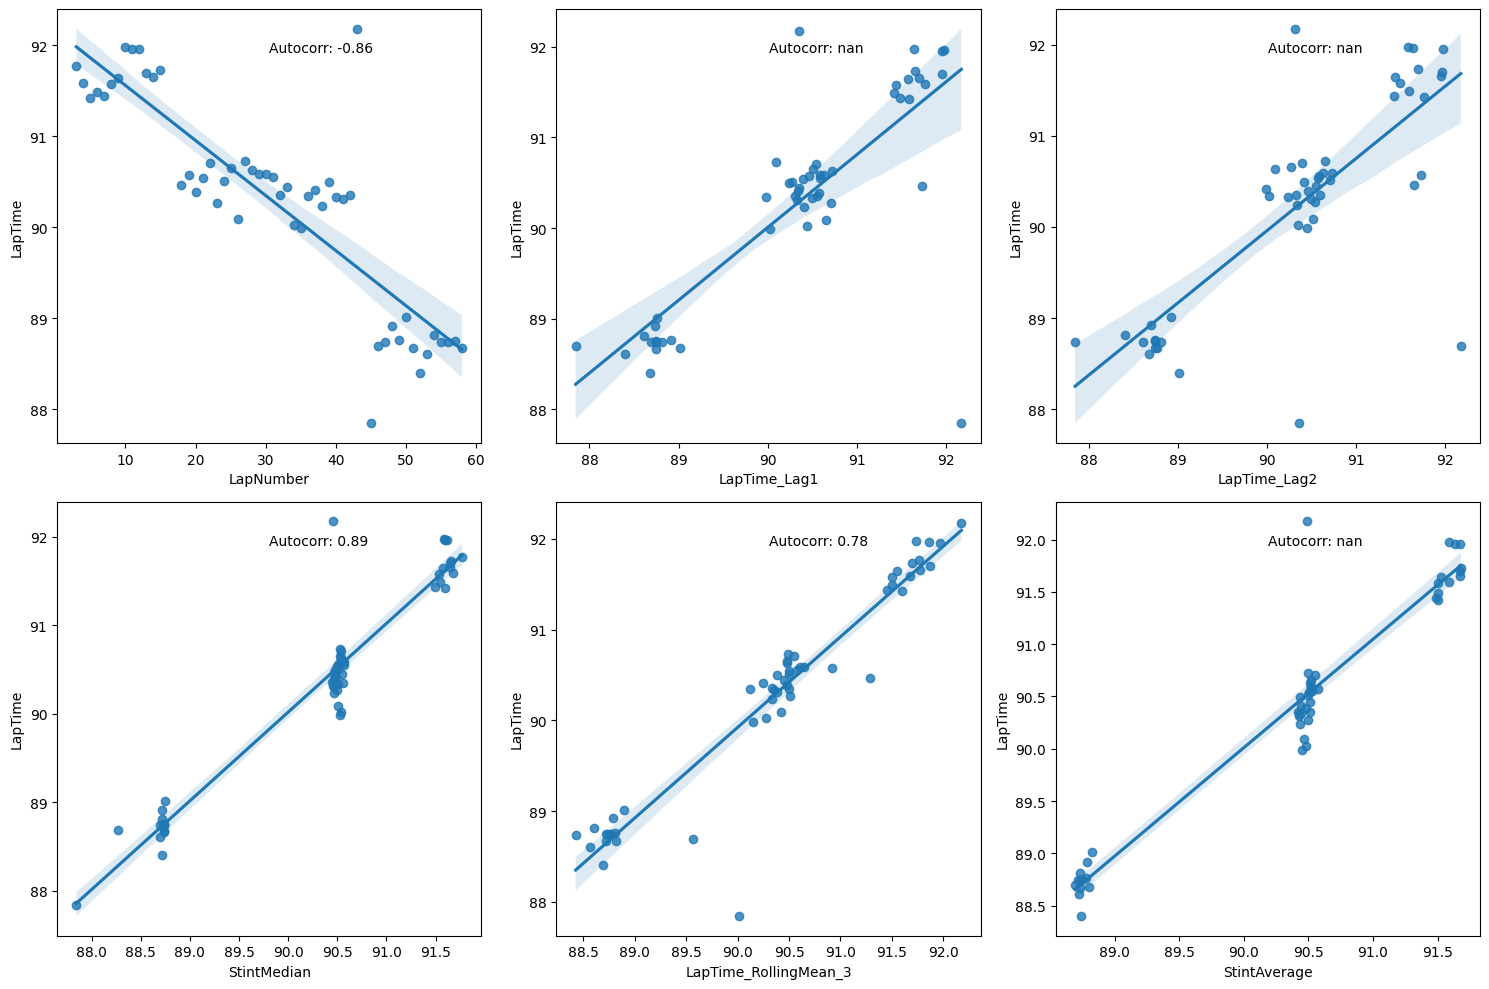

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Create the plots
plot_pairs = [
    ('LapNumber', 'LapTime'),
    ('LapTime_Lag1', 'LapTime'),
    ('LapTime_Lag2', 'LapTime'),
    ('StintMedian', 'LapTime'),
    ('LapTime_RollingMean_3', 'LapTime'),
    ('StintAverage', 'LapTime')
]

# Create the plots
for i, (x, y) in enumerate(plot_pairs):
    ax = axs[i // 3, i % 3]
    sns.regplot(x=x, y=y, data=df_front, ax=ax)
    
    # Calculate the autocorrelation
    autocorr = np.corrcoef(df_front[x].values[:-1], df_front[y].values[1:])[0, 1]
    
    # Display the autocorrelation value on the plot
    ax.text(0.5, 0.9, f'Autocorr: {autocorr:.2f}', transform=ax.transAxes)

# Remove any unused subplots
for j in range(i + 1, 6):
    fig.delaxes(axs[j // 3, j % 3])

# Display the plots
plt.tight_layout()
plt.show()

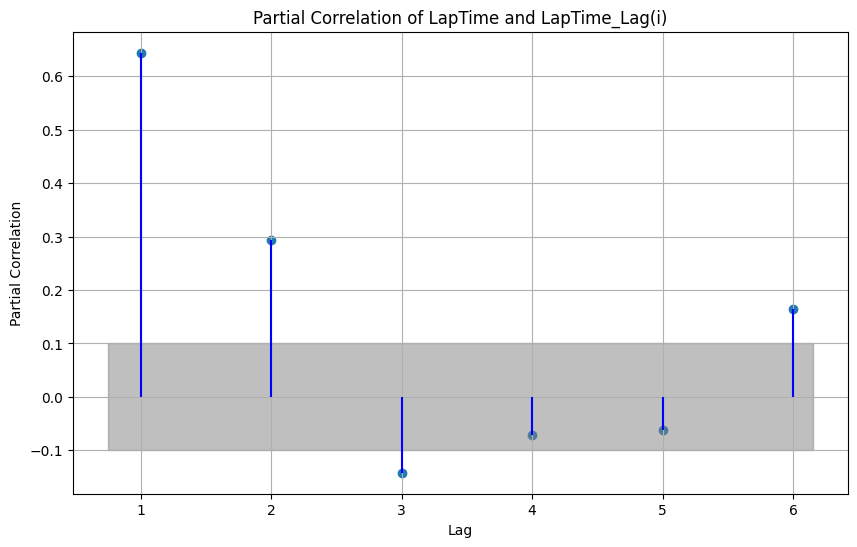

In [38]:
import statsmodels.api as sm
# Drop rows with NaN values from the entire DataFrame
df_behind_clean = df_behind[['LapTime', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_Lag3', 'LapTime_Lag4', 'LapTime_Lag5', 'LapTime_Lag6']].dropna()


# Initialize a list to store the partial correlations
partial_corrs = []

# Calculate the partial correlation for each lag
for i in range(1, 7):
    # Define the control variables
    control_vars = df_behind_clean.columns.difference(['LapTime', f'LapTime_Lag{i}']).tolist()
    
    # Fit the model
    model = sm.OLS(df_behind_clean['LapTime'], sm.add_constant(df_behind_clean[control_vars + [f'LapTime_Lag{i}']]))
    results = model.fit()
    
    # Get the partial correlation (which is the coefficient of 'LapTime_Lag(i)' in the model)
    partial_corr = results.params[f'LapTime_Lag{i}']
    partial_corrs.append(partial_corr)

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(range(1, 7), partial_corrs, marker='o')
plt.xlabel('Lag')
plt.ylabel('Partial Correlation')
plt.title('Partial Correlation of LapTime and LapTime_Lag(i)')
plt.grid(True)

# Get the limits of the x-axis
x_start, x_end = plt.xlim()

# Fill the area between 0.1 and -0.1
plt.fill_between(np.arange(x_start, x_end, 0.1), -0.1, 0.1, color='gray', alpha=0.5)

# Add vertical lines from the points to the x-axis
for i in range(1, 7):
    plt.vlines(i, 0, partial_corrs[i-1], color='blue')

plt.show()

<h2>A parciális korreláció plot alapján eldönthető, hogy hány Lag Feature-t érdemes használni a modellekben. Jelen esetben a Lag6 feature hamis pozitívnak tekinthető.</h2>

In [17]:
def regression_model_fit(train_data, features, target, model=None):
    """
    Fits a regression model to the training data.
    
    Parameters:
    train_data: DataFrame - the training data
    features: list - the list of features to train the model on
    target: str - the name of the target column
    model: a scikit-learn model (default is LinearRegression)
    
    Returns:
    model: the fitted regression model
    """
    X = train_data[features]
    y = train_data[target]

    # Use the passed model or default to LinearRegression
    if model is None:
        model = LinearRegression()

    model.fit(X, y)

    return model

In [18]:
def regression_model_predict(model, X_test, features):
    """
    Makes predictions using the fitted regression model.
    
    Parameters:
    model: the fitted regression model
    X_test: DataFrame - the test data
    features: list - the list of features to use for prediction
    
    Returns:
    predictions: array - predicted values
    """
    X = X_test[features]
    predictions = model.predict(X)
    
    return predictions


In [97]:
df_race['StintLapNumber'] = df_race.groupby(['Driver', 'Stint']).cumcount()+1
time_dummies = ['LapNumber', 'StintLapNumber', 'TyreLife']
time_combos = []
for i in range(1, len(time_dummies)+1):
    combos = itertools.combinations(time_dummies,i)
    for combo in combos:
        time_combos.append(list(combo))

print(time_combos)

[['LapNumber'], ['StintLapNumber'], ['TyreLife'], ['LapNumber', 'StintLapNumber'], ['LapNumber', 'TyreLife'], ['StintLapNumber', 'TyreLife'], ['LapNumber', 'StintLapNumber', 'TyreLife']]


In [37]:
import itertools

# Feature list with LapNumber always included
base_feature = ['LapNumber']
other_features = ['StintMedian', 'LapTime_Lag1', 'LapTime_Lag2', 
                  'LapTime_Lag3', 'RollingMean', 'StintMean']

# Generate all possible combinations of other features
feature_combinations = []
feature_combinations.append(base_feature)
for r in range(1, len(other_features) + 1):
    combos = itertools.combinations(other_features, r)
    for combo in combos:
        feature_combinations.append(base_feature + list(combo))

# Print all feature combinations
for i, features in enumerate(feature_combinations, 1):
    print(f"Combination {i}: {features}")


Combination 1: ['LapNumber']
Combination 2: ['LapNumber', 'StintMedian']
Combination 3: ['LapNumber', 'LapTime_Lag1']
Combination 4: ['LapNumber', 'LapTime_Lag2']
Combination 5: ['LapNumber', 'LapTime_Lag3']
Combination 6: ['LapNumber', 'RollingMean']
Combination 7: ['LapNumber', 'StintMean']
Combination 8: ['LapNumber', 'StintMedian', 'LapTime_Lag1']
Combination 9: ['LapNumber', 'StintMedian', 'LapTime_Lag2']
Combination 10: ['LapNumber', 'StintMedian', 'LapTime_Lag3']
Combination 11: ['LapNumber', 'StintMedian', 'RollingMean']
Combination 12: ['LapNumber', 'StintMedian', 'StintMean']
Combination 13: ['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2']
Combination 14: ['LapNumber', 'LapTime_Lag1', 'LapTime_Lag3']
Combination 15: ['LapNumber', 'LapTime_Lag1', 'RollingMean']
Combination 16: ['LapNumber', 'LapTime_Lag1', 'StintMean']
Combination 17: ['LapNumber', 'LapTime_Lag2', 'LapTime_Lag3']
Combination 18: ['LapNumber', 'LapTime_Lag2', 'RollingMean']
Combination 19: ['LapNumber', 'LapTime_L

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(predictions_df, actual_lap_times_df):
    # Merge predictions with actual lap times
    merged_df = pd.merge(predictions_df, actual_lap_times_df[['Driver', 'LapNumber', 'LapTime']],
                         on=['Driver', 'LapNumber'], how='left', suffixes=('_pred', '_actual'))

    # Group by FeatureSetIndex and Bucket
    grouped = merged_df.groupby(['FeatureSetIndex', 'Bucket'])

    # Initialize lists to store metrics
    mae_list = []
    mse_list = []

    # Loop through each group and calculate metrics
    for (featureset_index, bucket), group in grouped:
        actual = group['LapTime_actual']
        predicted = group['PredictedLapTime']
        
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        
        mae_list.append({'FeatureSetIndex': featureset_index, 'Bucket': bucket, 'MAE': mae})
        mse_list.append({'FeatureSetIndex': featureset_index, 'Bucket': bucket, 'MSE': mse})

    # Convert lists to DataFrames
    mae_df = pd.DataFrame(mae_list)
    mse_df = pd.DataFrame(mse_list)

    # Merge MAE and MSE results into a single DataFrame
    metrics_df = pd.merge(mae_df, mse_df, on=['FeatureSetIndex', 'Bucket'])
    
    return metrics_df


In [75]:
def make_predictions_for_race(df_race, feature_combinations, target='LapTime', min_lap=10, max_forecast_laps=25, bucket_size=5):
    # Create a DataFrame to store predictions
    
    unique_drivers = df_race['Driver'].unique()
    predictions_list = []

    # Loop over each driver
    for driver in unique_drivers:
        df_driver = df_race[df_race['Driver'] == driver].copy()
        total_laps = int(df_driver['LapNumber'].max())

        # Start fitting and predicting after lap 10
        for current_lap in range(min_lap + 1, total_laps + 1):
            # Fit models and predict for each feature set
            for i, feature_set in enumerate(feature_combinations):
                # Get training data for laps <= current_lap
                train_data = df_driver[(df_driver['LapNumber'] > 1) &
                                       (df_driver['LapNumber'] <= current_lap)]
                
                # Fit the model on the available data
                model = regression_model_fit(train_data, feature_set, target)
                
                # Determine how many laps to forecast
                remaining_laps = total_laps - current_lap
                forecast_laps = min(remaining_laps, max_forecast_laps)

                # Create test data for the forecast range
                X_test = df_driver[(df_driver['LapNumber'] > current_lap) & 
                                   (df_driver['LapNumber'] <= current_lap + forecast_laps)]

                # Skip if no laps left to forecast
                if X_test.empty:
                    continue
                
                # Predict the lap times
                predicted_laps = regression_model_predict(model, X_test, feature_set)

                # Store predictions in the DataFrame, with bucket information
                for lap_num, pred in zip(X_test['LapNumber'], predicted_laps):
                    
                    laps_ahead = lap_num - current_lap
                    bucket = (laps_ahead // bucket_size) + 1

                    predictions_list.append({
                        'Driver': driver,
                        'LapNumber': lap_num,
                        'FeatureSetIndex': i,
                        'PredictedLapTime': pred,
                        'Bucket': bucket
                    })
    predictions_df = pd.DataFrame(predictions_list)


    return predictions_df


In [ ]:
df_race = df_race.dropna(subset=other_features)

In [98]:
abu_dummies = make_predictions_for_race(df_race, time_combos)

In [77]:
abu_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081728 entries, 0 to 1081727
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Driver            1081728 non-null  object 
 1   LapNumber         1081728 non-null  float64
 2   FeatureSetIndex   1081728 non-null  int64  
 3   PredictedLapTime  1081728 non-null  float64
 4   Bucket            1081728 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 41.3+ MB


In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(predictions_df, actual_lap_times_df, slow_lap_threshold=1.07):
    # Identify the fastest lap for each driver
    fastest_lap_times = actual_lap_times_df.groupby('Driver')['LapTime'].min()

    # Calculate the max allowed LapTime for each driver (slow lap threshold)
    actual_lap_times_df = actual_lap_times_df.copy()
    actual_lap_times_df['MaxAllowedLapTime'] = actual_lap_times_df['Driver'].map(fastest_lap_times) * slow_lap_threshold

    # Filter out slow laps in the actual data
    actual_lap_times_df = actual_lap_times_df[actual_lap_times_df['LapTime'] <= actual_lap_times_df['MaxAllowedLapTime']]

    # Merge predictions with filtered actual lap times
    merged_df = pd.merge(predictions_df, actual_lap_times_df[['Driver', 'LapNumber', 'LapTime']],
                         on=['Driver', 'LapNumber'], how='left')

    # Group by FeatureSetIndex and Bucket
    grouped = merged_df.groupby(['FeatureSetIndex', 'Bucket'])

    # Initialize lists to store metrics
    mae_list = []
    mse_list = []

    # Loop through each group and calculate metrics
    for (featureset_index, bucket), group in grouped:
        actual = group['LapTime']  # This is the actual lap time
        predicted = group['PredictedLapTime']  # This is the predicted lap time
        
        mae = mean_absolute_error(actual.dropna(), predicted[actual.notna()])  # Ensure no NaN in the metrics
        mse = mean_squared_error(actual.dropna(), predicted[actual.notna()])
        
        mae_list.append({'FeatureSetIndex': featureset_index, 'Bucket': bucket, 'MAE': mae})
        mse_list.append({'FeatureSetIndex': featureset_index, 'Bucket': bucket, 'MSE': mse})

    # Convert lists to DataFrames
    mae_df = pd.DataFrame(mae_list)
    mse_df = pd.DataFrame(mse_list)

    # Merge MAE and MSE results into a single DataFrame
    metrics_df = pd.merge(mae_df, mse_df, on=['FeatureSetIndex', 'Bucket'])
    
    return metrics_df


In [83]:
abu_metrics = calculate_metrics(abu_predictions, df_race)

In [101]:
best_10_featureset = abu_metrics.groupby(['FeatureSetIndex']).mean().sort_values('MAE').head(10)
print(best_10_featureset)

                 Bucket   MAE   MSE
FeatureSetIndex                    
0                 3.500 1.253 3.570
2                 3.500 1.308 5.513
4                 3.500 1.422 4.621
3                 3.500 1.426 5.733
5                 3.500 1.486 6.354
12                3.500 1.518 7.848
17                3.500 1.521 6.981
6                 3.500 1.547 6.068
21                3.500 1.551 8.395
40                3.500 1.552 8.453


In [100]:
dummie_scores = calculate_metrics(abu_dummies, df_race)
best_10_featureset = dummie_scores.groupby(['FeatureSetIndex']).mean().sort_values('MAE').head(10)
print(best_10_featureset)

                 Bucket               MAE                              MSE
FeatureSetIndex                                                           
0                 3.500             1.253                            3.570
2                 3.500             1.727                            3.839
1                 3.500             1.758                            4.036
5                 3.500  192155959348.787   13300388395198781784588288.000
6                 3.500  693506076130.170  256073354920900280488820736.000
3                 3.500 1615777282548.856  973345278994000371448283136.000
4                 3.500 1807933241895.688 1213004927645606330687815680.000


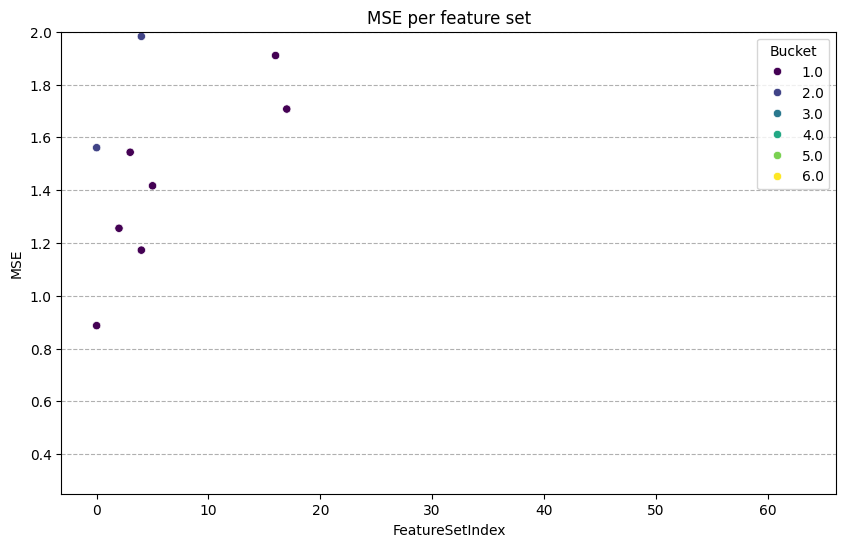

In [81]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=abu_metrics, x='FeatureSetIndex', y='MSE', hue='Bucket', palette='viridis')
plt.ylim(0.25, 2)
plt.grid(visible=True, which='major', axis='y', linestyle='--')

plt.title('MSE per feature set')
plt.legend(title='Bucket')
plt.show()

In [166]:
df_race = filter_for_race(df_all, 'Mexico City Grand Prix', 2021, team_encode=True)
df_race = remove_slow_laps(df_race)
df_race = add_lags(df_race, 5)
df_race = add_rolling_mean(df_race, 3)
df_race = add_stint_mean(df_race)

cols = ['DriverNumber', 'LapTime', 'LapNumber', 'Stint', 
       'SpeedFL', 'Compound', 'TyreLife',
       'FreshTyre', 'Team', 'Position', 'LapTime_Lag1',
       'LapTime_Lag2',
        'LapTime_Lag3', 
        'LapTime_Lag4', 
       'LapTime_Lag5',  'LapTime_RollingMean_3',
       'StintAverage']
df = df_race[cols].dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 5 to 891
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DriverNumber           800 non-null    int64  
 1   LapTime                800 non-null    float64
 2   LapNumber              800 non-null    float64
 3   Stint                  800 non-null    float64
 4   SpeedFL                800 non-null    float64
 5   Compound               800 non-null    int64  
 6   TyreLife               800 non-null    float64
 7   FreshTyre              800 non-null    bool   
 8   Team                   800 non-null    int64  
 9   Position               800 non-null    float64
 10  LapTime_Lag1           800 non-null    float64
 11  LapTime_Lag2           800 non-null    float64
 12  LapTime_Lag3           800 non-null    float64
 13  LapTime_Lag4           800 non-null    float64
 14  LapTime_Lag5           800 non-null    float64
 15  LapTime_Rol

/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_17082/3447590014.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_17082/3447590014.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_17082/3286590795.py:13: DeprecationWarning: DataFrameGroupBy.apply 

In [148]:
mi_scores_df = pd.DataFrame(columns=['Feature', 'Score'])

In [167]:
#import pandas as pd
from sklearn.feature_selection import mutual_info_regression
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler

# Load your data


# Assume 'Compound' and 'Team' are the categorical features to be encoded
#categorical_features = ['Compound', 'Team']

# Setup the preprocessor
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', StandardScaler(), ['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_Lag3', 'StintAverage']),  # Numeric features
#        ('cat', OneHotEncoder(), categorical_features)  # Categorical features
#    ])

# Apply preprocessing
#X = preprocessor.fit_transform(data.drop(['LapTime'], axis=1))
#y = data['LapTime']

X = df[cols].drop(['LapTime'], axis=1)
y = df['LapTime']

features = X.columns.tolist()

# Compute Mutual Information
mi_scores = mutual_info_regression(X, y)

# Get feature names after one-hot encoding
#feature_names = (['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_Lag3', 'StintAverage'] +
#                 list(preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)))

# Create a Series for the scores
temp_df = pd.DataFrame({
    'Feature': features,
    'Score': mi_scores
})
mi_scores_df = pd.concat([mi_scores_df, temp_df], ignore_index=True)
# Print the scores
mi_scores_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Feature  144 non-null    object 
 1   Score    144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [168]:
# Calculate the mean MI score for each feature
mean_mi_scores = mi_scores_df.groupby('Feature')['Score'].mean().reset_index()
mean_mi_scores = mean_mi_scores.sort_values(by='Score', ascending=False)
# Print the mean MI scores
print(mean_mi_scores)

                  Feature  Score
9   LapTime_RollingMean_3  1.180
4            LapTime_Lag1  0.797
13           StintAverage  0.787
5            LapTime_Lag2  0.623
6            LapTime_Lag3  0.508
7            LapTime_Lag4  0.434
8            LapTime_Lag5  0.387
3               LapNumber  0.333
1            DriverNumber  0.298
10               Position  0.275
14                   Team  0.262
12                  Stint  0.219
11                SpeedFL  0.188
15               TyreLife  0.122
0                Compound  0.061
2               FreshTyre  0.028


In [22]:
xg_features = ['LapTime_RollingMean_3',
               'LapTime_Lag1',
               'StintAverage',
               'LapTime_Lag2',
               'LapTime_Lag3',
               'LapTime_Lag4',
               'LapTime_Lag5',
               'LapNumber',
               'Driver',
               'Position',
               'Team'
              ]

In [23]:
def get_xg_pipeline(colsample_bytree=0.5, learning_rate=0.3, max_depth=6, alpha=15, n_estimators=5000, min_child_weight=30):
    # Encoding categorical data
    categorical_feature = ['Driver']
    one_hot_encoder = OneHotEncoder()

    # Column transformer to apply transformations to the appropriate columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', one_hot_encoder, categorical_feature)],
        remainder='passthrough')

    # Initialize XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=colsample_bytree, learning_rate=learning_rate,
                            max_depth=max_depth, alpha=alpha, n_estimators=n_estimators, min_child_weight=min_child_weight)

    # Combine preprocessor and model into a pipeline
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('regressor', model)])

    return model_pipeline

In [24]:
def train_xg(df_race, features):
    # Define features and target variable
    X = df_race[features]
    y = df_race['LapTime']

    # Fit the model
    model_pipeline = get_xg_pipeline(colsample_bytree=0.8, learning_rate=0.2, max_depth=4, alpha=0, n_estimators=500, min_child_weight=1)
    model_pipeline.fit(X, y)

    return model_pipeline


In [37]:
def xg_predict(model_pipeline, df_race, xg_features, driver, num_future_laps):
    
    # Initialize feature set for the first prediction
    features = df_race.loc[df_race['Driver'] == driver].iloc[-1]  # Get the last record of selected driver
    predictions = []

    # A jelenlegi stint köridejei
    current_stint = features['Stint']
    stint_laptimes = df_race.loc[(df_race['Driver'] == driver) & (df_race['Stint'] == current_stint), 'LapTime']

    features['LapTime_Lag5'] = features['LapTime_Lag4']
    features['LapTime_Lag4'] = features['LapTime_Lag3']
    features['LapTime_Lag3'] = features['LapTime_Lag2']
    features['LapTime_Lag2'] = features['LapTime_Lag1']
    features['LapTime_Lag1'] = features['LapTime']
    features['LapNumber'] += 1

    for i in range(num_future_laps):
        # Update features for the prediction
        lap_features = pd.DataFrame([features], columns=features.index)
        lap_features = lap_features[xg_features]
        
        # Predict the next lap time
        next_lap_time = model_pipeline.predict(lap_features)[0]
        predictions.append(next_lap_time)

        # Update features for the next lap
        features['LapTime_RollingMean_3'] = (next_lap_time + features['LapTime_Lag1'] + features['LapTime_Lag2']) / 3
        features['LapTime_Lag5'] = features['LapTime_Lag4']
        features['LapTime_Lag4'] = features['LapTime_Lag3']
        features['LapTime_Lag3'] = features['LapTime_Lag2']
        features['LapTime_Lag2'] = features['LapTime_Lag1']
        features['LapTime_Lag1'] = next_lap_time
        features['LapNumber'] += 1

        # Update StintAverage
        stint_laptimes = pd.concat([stint_laptimes, pd.Series([next_lap_time])])
        features['StintAverage'] = stint_laptimes.mean()


    # Output predictions
    return predictions

In [26]:

def xg_train_and_evaluate(train_data, test_data, driver, n_laps_predict, target='LapTime', features=['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_RollingMean_3']):
    # Train the model
    #model = regression_model_fit(train_data, features, target)
    #### Use custom function to predict !!!
    #predictions = predict_lap_times(model, train_data, 5)
    #predictions = regression_model_predict(model, train_data, 5) # not the name of the function
    
    model_pipeline = train_xg(train_data, xg_features)
    
    predictions = xg_predict(model_pipeline, train_data, xg_features, driver, n_laps_predict)
    
    # Calculate the metrics
    mae = mean_absolute_error(test_data[target], predictions)
    mse = mean_squared_error(test_data[target], predictions)
    
    # Create a DataFrame for the results
    result_df = pd.DataFrame({
        'mae': [mae],
        'mse': [mse]
    })

    return predictions, result_df


In [27]:
def xg_train_test_split(df_race, current_lap):
    df_race = remove_slow_laps(df_race)
    df_train, df_test = train_test_split(df_race, current_lap)
    #df_train = df_train[df_train['Driver'] == driver]
    df_test, _ = train_test_split(df_test, current_lap + 5)
    #df_test = df_test[df_test['Driver'] == driver]
    df_train = add_lags(df_train, 5)
    df_train = add_rolling_mean(df_train)
    df_train = add_stint_mean(df_train)

    return df_train, df_test

In [357]:
df_race = filter_for_race(df_all, 'Abu Dhabi Grand Prix', 2023, team_encode=True)
h_train_data, h_test_data = xg_train_test_split(df_race, 30, 'HAM')
p_train_data, p_test_data = xg_train_test_split(df_race, 30, 'ALO')


/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_20699/3447590014.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_20699/3447590014.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_20699/2350675283.py:3: SettingWithCopyWarning: 
A value is trying t

In [366]:
preds, acc = xg_train_and_evaluate(h_train_data, h_test_data, 'HAM')
acc

,features,mae,mse
0,"[LapNumber, LapTime_Lag1, LapTime_Lag2, LapTim...",0.084,0.017


In [364]:
preds, acc = xg_train_and_evaluate(p_train_data, p_test_data, 'ALO')
acc

,features,mae,mse
0,"[LapNumber, LapTime_Lag1, LapTime_Lag2, LapTim...",0.232,0.067


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameters grid
param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'alpha': [10, 20],
    'n_estimators': [50, 100, 200]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit GridSearchCV
grid_search.fit(X, y)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)


In [28]:
import itertools

def predict_striking_distance(lap_times_behind, lap_times_front, initial_gap):
    gap = initial_gap
    for i, (time_behind, time_front) in enumerate(zip(lap_times_behind, lap_times_front), start=1):
        gap += time_behind - time_front
        if gap < 1:
            return i
    return float('inf')

In [29]:
def average_predictions(model1, model2):
    return [(m1 + m2) / 2 for m1, m2 in zip(model1, model2)]

In [30]:
def evaluate_combined(test_data, predictions):
    mae = mean_absolute_error(test_data['LapTime'], predictions)
    mse = mean_squared_error(test_data['LapTime'], predictions)

    return pd.DataFrame({
        'mae': [mae],
        'mse': [mse]
    })

In [96]:
def battle_prediction(all_race_data, year, racename, driver_behind, driver_front, lap_of_race, n_laps_predict):
    # Verseny adatokra szűrés
    df_race = filter_for_race(all_race_data, racename, year, team_encode=True)

    #Lineáris Regresszió
    r_train_behind, r_train_front, test_behind, test_front = prediction_context(df_race.copy(), driver_behind, driver_front, lap_of_race, n_laps_predict)
    r_behind_times, r_behind_accuracy = train_and_evaluate(r_train_behind, test_behind, n_laps_predict)
    r_front_times, r_front_accuracy = train_and_evaluate(r_train_front, test_front, n_laps_predict)
    
    # XGBoost Regresszió
    train_data, _ = xg_train_test_split(df_race.copy(), lap_of_race)
    x_behind_times, x_behind_accuracy = xg_train_and_evaluate(train_data, test_behind, driver_behind, n_laps_predict)
    x_front_times, x_front_accuracy = xg_train_and_evaluate(train_data, test_front, driver_front, n_laps_predict)
    
    # Átlagolt predikciók
    combined_behind_times = average_predictions(r_behind_times, x_behind_times)
    combined_front_times = average_predictions(r_front_times, x_front_times)
    combined_behind_accuracy = evaluate_combined(test_behind, combined_behind_times)
    combined_front_accuracy = evaluate_combined(test_front, combined_front_times)

    # Két pilóta közötti távolság a predikció idején
    gap_between = r_train_behind['CumulativeTime'].iloc[-1] - r_train_front['CumulativeTime'].iloc[-1]
    
    # Támadási távolság kialakulásának kiszámítása
    regression_predicted_laps = predict_striking_distance(r_behind_times, r_front_times, gap_between)
    xgboost_predicted_laps = predict_striking_distance(x_behind_times, x_front_times, gap_between)
    combined_predicted_laps = predict_striking_distance(combined_behind_times, combined_front_times, gap_between)
    
    result_df = pd.DataFrame({
        'Year' : [year],
        'RaceName' : [racename],
        'ChasingBehind' : [driver_behind],
        'ChasingFront' : [driver_front],
        'LeadLapofthePrediction' : [lap_of_race],
        'RegressionPredictedLaps' : [regression_predicted_laps],
        'Regression_mae' : [(r_behind_accuracy['mae'].values[0] + r_front_accuracy['mae'].values[0]) / 2],
        'Regression_mse' : [(r_behind_accuracy['mse'].values[0] + r_front_accuracy['mse'].values[0]) / 2],
        'XGBoostPredictedLaps' : [xgboost_predicted_laps],
        'XGB_mae' : [(x_behind_accuracy['mae'].values[0] + x_front_accuracy['mae'].values[0]) / 2],
        'XGB_mse' : [(x_behind_accuracy['mse'].values[0] + x_front_accuracy['mse'].values[0]) / 2],
        'CombinedPredictedLaps' : [combined_predicted_laps],
        'Combined_mae' : [(combined_behind_accuracy['mae'].values[0] + combined_front_accuracy['mae'].values[0]) / 2],
        'Combined_mse' : [(combined_behind_accuracy['mse'].values[0] + combined_front_accuracy['mse'].values[0]) / 2]
    })

    return result_df


In [97]:
def battle_prediction(all_race_data, year, racename, driver_behind, driver_front, lap_of_race, n_laps_predict):
    # Verseny adatokra szűrés
    df_race = filter_for_race(all_race_data, racename, year, team_encode=True)
    df_race = remove_slow_laps(df_race)

    #Lineáris Regresszió
    r_train_behind, r_train_front, test_behind, test_front = prediction_context(df_race.copy(), driver_behind, driver_front, lap_of_race, n_laps_predict)
    r_behind_times, r_behind_accuracy = train_and_evaluate(r_train_behind, test_behind, n_laps_predict)
    r_front_times, r_front_accuracy = train_and_evaluate(r_train_front, test_front, n_laps_predict)
    
    # XGBoost
    train_data, _ = xg_train_test_split(df_race.copy(), lap_of_race)
    xbtrain = train_data[train_data['Driver']==driver_behind]
    xftrain = train_data[train_data['Driver']==driver_front]
    x_behind_times, x_behind_accuracy = xg_train_and_evaluate(xbtrain, test_behind, driver_behind, n_laps_predict)
    x_front_times, x_front_accuracy = xg_train_and_evaluate(xftrain, test_front, driver_front, n_laps_predict)
    
    # Átlagolt predikciók
    combined_behind_times = average_predictions(r_behind_times, x_behind_times)
    combined_front_times = average_predictions(r_front_times, x_front_times)
    combined_behind_accuracy = evaluate_combined(test_behind, combined_behind_times)
    combined_front_accuracy = evaluate_combined(test_front, combined_front_times)

    # Két pilóta közötti távolság a predikció idején
    gap_between = r_train_behind['CumulativeTime'].iloc[-1] - r_train_front['CumulativeTime'].iloc[-1]
    print("Gap: ")
    print(gap_between)
    
    # Támadási távolság kialakulásának kiszámítása
    regression_predicted_laps = predict_striking_distance(r_behind_times, r_front_times, gap_between)
    xgboost_predicted_laps = predict_striking_distance(x_behind_times, x_front_times, gap_between)
    combined_predicted_laps = predict_striking_distance(combined_behind_times, combined_front_times, gap_between)
    
    result_df = pd.DataFrame({
        'Year' : [year],
        'RaceName' : [racename],
        'ChasingBehind' : [driver_behind],
        'ChasingFront' : [driver_front],
        'LeadLapofthePrediction' : [lap_of_race],
        'RegressionPredictedLaps' : [regression_predicted_laps],
        'Regression_mae' : [(r_behind_accuracy['mae'].values[0] + r_front_accuracy['mae'].values[0]) / 2],
        'Regression_mse' : [(r_behind_accuracy['mse'].values[0] + r_front_accuracy['mse'].values[0]) / 2],
        'XGBoostPredictedLaps' : [xgboost_predicted_laps],
        'XGB_mae' : [(x_behind_accuracy['mae'].values[0] + x_front_accuracy['mae'].values[0]) / 2],
        'XGB_mse' : [(x_behind_accuracy['mse'].values[0] + x_front_accuracy['mse'].values[0]) / 2],
        'CombinedPredictedLaps' : [combined_predicted_laps],
        'Combined_mae' : [(combined_behind_accuracy['mae'].values[0] + combined_front_accuracy['mae'].values[0]) / 2],
        'Combined_mse' : [(combined_behind_accuracy['mse'].values[0] + combined_front_accuracy['mse'].values[0]) / 2]
    })

    return result_df


In [100]:
test_df = battle_prediction(df_all, 2019, 'United States Grand Prix', 'BOT', 'HAM',45,10)
# 2023, 'Singapore Grand Prix', 'RUS', 'NOR',56, 5
# 2023, 'Austrian Grand Prix', 'VER', 'LEC', 31, 5
# 2021, 'Spanish Grand Prix' ,'HAM','VER',48,10
# 2021, 'French Grand Prix', 'VER', 'BOT',38,6

Gap: 
3.4279999999998836


In [101]:
test_df

,Year,RaceName,ChasingBehind,ChasingFront,LeadLapofthePrediction,RegressionPredictedLaps,Regression_mae,Regression_mse,XGBoostPredictedLaps,XGB_mae,XGB_mse,CombinedPredictedLaps,Combined_mae,Combined_mse
0,2019,United States Grand Prix,BOT,HAM,45,inf,0.655,0.692,9,0.697,0.766,inf,0.639,0.695


In [82]:
aws_battle_predictions = pd.read_csv('AWS_battle_predictions_no_data_issue.csv')
import warnings
warnings.filterwarnings('ignore')

In [92]:
# Filter the DataFrame
filtered_aws_battle_predictions = aws_battle_predictions[aws_battle_predictions['PredictedLaps'] <= 5]

# Get unique combinations of Year, RaceName, ChasingBehind, ChasingFront, and LeadLapofthePrediction
unique_combinations = filtered_aws_battle_predictions[['Year', 'RaceName', 'ChasingBehind', 'ChasingFront', 'LeadLapofthePrediction']].drop_duplicates()
unique_combinations = unique_combinations[~(((unique_combinations['Year'] == 2023) & 
                                             (unique_combinations['RaceName'] == 'Hungarian') & 
                                             (unique_combinations['ChasingBehind'] == 'RUS') & 
                                             (unique_combinations['ChasingFront'] == 'ALO') & 
                                             (unique_combinations['LeadLapofthePrediction'] == 42)) |
                                            ((unique_combinations['Year'] == 2023) & 
                                             (unique_combinations['RaceName'] == 'Brazil') & 
                                             (unique_combinations['ChasingBehind'] == 'PER') & 
                                             (unique_combinations['ChasingFront'] == 'ALO') & 
                                             (unique_combinations['LeadLapofthePrediction'] == 32)) |
                                            ((unique_combinations['Year'] == 2023) & 
                                             (unique_combinations['RaceName'] == 'Spanish') & 
                                             (unique_combinations['ChasingBehind'] == 'RUS') & 
                                             (unique_combinations['ChasingFront'] == 'SAI') & 
                                             (unique_combinations['LeadLapofthePrediction'] == 33)) |
                                            ((unique_combinations['Year'] == 2023) & 
                                             (unique_combinations['RaceName'] == 'Bahrain') & 
                                             (unique_combinations['ChasingBehind'] == 'ALO') & 
                                             (unique_combinations['ChasingFront'] == 'SAI') & 
                                             (unique_combinations['LeadLapofthePrediction'] == 40)))]
# Initialize an empty DataFrame to store the results
last_own_battle_predictions = pd.DataFrame()

# Loop over the unique combinations and call the battle_prediction function for each one
for row in unique_combinations.itertuples(index=False):
    year, race_name, chasing_behind, chasing_front, lead_lap = row
    print(year, race_name, chasing_behind, chasing_front, lead_lap)
    try:
        battle_pred_df = battle_prediction(df_all, year, race_name + ' Grand Prix', chasing_behind, chasing_front, lead_lap, 20)
        # Concatenate the result to the own_battle_predictions DataFrame
        last_own_battle_predictions = pd.concat([last_own_battle_predictions, battle_pred_df], ignore_index=True)
    except ValueError as e:
        print(f"Error occurred: {e}. Skipping this combination.")

2023 Hungarian HAM PIA 54
2023 Hungarian PER HAM 33
2023 Abu Dhabi HAM ALO 30
2023 Miami HAM LEC 50
2023 Austrian VER LEC 31
2023 Austrian PER ALO 39
2023 Singapore RUS NOR 56
2022 Miami HAM BOT 36
2022 Spanish SAI BOT 53
2022 Spanish VER RUS 33
2022 Azerbaijan HAM GAS 33
2022 Canadian ALO LEC 38
2022 Canadian RUS ALO 27
2022 Austrian SAI VER 36
2022 French SAI NOR 45
2022 Hungarian HAM SAI 58
2022 Hungarian HAM SAI 46
2022 Dutch HAM PER 34
2022 Dutch VER RUS 23
2022 São Paulo HAM PER 39
2022 São Paulo HAM SAI 33
2021 Portuguese BOT VER 45
2021 French VER BOT 38
2021 Styrian PER BOT 39
2021 Austrian NOR BOT 52
2021 Austrian BOT HAM 42
2021 Dutch NOR OCO 51
2021 Dutch VER BOT 25
2021 Russian HAM NOR 33
2021 Turkish HAM PER 22
2021 Mexico City PER HAM 57
2020 Styrian BOT VER 65
2020 Styrian BOT VER 24
2020 Hungarian BOT VER 40
2020 Hungarian BOT STR 23
2020 Hungarian BOT STR 13
Error occurred: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by LinearRegressio

In [86]:
print("Average Regression MAE:", own_battle_predictions['Regression_mae'].mean())
print("Average Regression MSE:", own_battle_predictions['Regression_mse'].mean())
print("Average XGB MAE:", own_battle_predictions['XGB_mae'].mean())
print("Average XGB MSE:", own_battle_predictions['XGB_mse'].mean())
print("Average Combined MAE:", own_battle_predictions['Combined_mae'].mean())
print("Average Combined MSE:", own_battle_predictions['Combined_mse'].mean())

Average Regression MAE: 0.40967450112437975
Average Regression MSE: 0.36400641198288336
Average XGB MAE: 0.43427611231310576
Average XGB MSE: 0.4176122059668495
Average Combined MAE: 0.4004509401489473
Average Combined MSE: 0.35298254933269213


In [81]:
own_battle_predictions.to_csv('own_battle_predictions.csv', index=False)

In [ ]:
filtered_aws_battle_predictions.info()

In [93]:
last_own_battle_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     45 non-null     int64  
 1   RaceName                 45 non-null     object 
 2   ChasingBehind            45 non-null     object 
 3   ChasingFront             45 non-null     object 
 4   LeadLapofthePrediction   45 non-null     int64  
 5   RegressionPredictedLaps  45 non-null     float64
 6   XGBoostPredictedLaps     45 non-null     float64
 7   CombinedPredictedLaps    45 non-null     float64
dtypes: float64(3), int64(2), object(3)
memory usage: 2.9+ KB


In [95]:
last_own_battle_predictions.to_csv('last_own_battle_predictions.csv', index=False)